# **Recommendation System 1**

In [ ]:
!pip install -q tensorflow-recommenders
!pip install -q --upgrade tensorflow-datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.2/96.2 kB 2.9 MB/s eta 0:00:00


*Installs TensorFlow Recommenders and upgrades TensorFlow Datasets to the latest version, essential for building and managing recommendation systems.*

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np

# Load the dataset
ratings = tfds.load("movielens/100k-ratings", split="train")
movies = tfds.load("movielens/100k-movies", split="train")

# Preprocess the ratings to get unique user IDs
ratings = ratings.map(lambda x: {
    "movie_title": x["movie_title"],
    "user_id": x["user_id"],
    "user_rating": x["user_rating"]
})

# Preprocess the movies to get movie titles
movies = movies.map(lambda x: x["movie_title"])

# Convert the datasets to a unique list of movie titles and user IDs
unique_movie_titles = []
unique_user_ids = []

# Convert movies to a list
for movie in movies:
    unique_movie_titles.append(movie.numpy().decode('utf-8'))

# Convert user_ids to a list
for rating in ratings:
    unique_user_ids.append(rating['user_id'].numpy().decode('utf-8'))

# Remove duplicates
unique_movie_titles = list(set(unique_movie_titles))
unique_user_ids = list(set(unique_user_ids))

print("Unique movie titles:", unique_movie_titles[:5])  # Show a few examples
print("Unique user IDs:", unique_user_ids[:5])          # Show a few examples

# Ensure the lengths are correct
print(f"Number of unique movie titles: {len(unique_movie_titles)}")
print(f"Number of unique user IDs: {len(unique_user_ids)}")


Unique movie titles: ["I'm Not Rappaport (1996)", 'Love! Valour! Compassion! (1997)', 'Fly Away Home (1996)', 'Shining, The (1980)', 'Philadelphia Story, The (1940)']
Unique user IDs: ['690', '832', '279', '147', '703']
Number of unique movie titles: 1664
Number of unique user IDs: 943


*Imports TensorFlow for model building, TensorFlow Datasets for loading pre-built datasets, and NumPy for numerical operations.Loads the "movielens/100k-ratings" and "movielens/100k-movies" datasets, which contain user ratings and movie details respectively.Maps and extracts relevant fields from the ratings dataset, such as movie titles, user IDs, and user ratings.Extracts movie titles from the movies dataset, focusing on the titles for the recommendation system.Creates lists of unique movie titles and user IDs from the datasets, ensuring no duplicates.Prints a sample of unique movie titles and user IDs, and the total counts for each to verify the dataset's content.*

In [ ]:
import tensorflow_recommenders as tfrs

# Set up embeddings
embedding_dimension = 32

# Create user and movie models
user_model = tf.keras.Sequential([
    tf.keras.layers.StringLookup(
        vocabulary=unique_user_ids, mask_token=None),
    tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
])

movie_model = tf.keras.Sequential([
    tf.keras.layers.StringLookup(
        vocabulary=unique_movie_titles, mask_token=None),
    tf.keras.layers.Embedding(len(unique_movie_titles) + 1, embedding_dimension)
])

# Set up the retrieval task
task = tfrs.tasks.Retrieval(
    metrics=tfrs.metrics.FactorizedTopK(
        candidates=movies.batch(128).map(movie_model)
    )
)

# Create the model class
class MovielensModel(tfrs.Model):

    def __init__(self, user_model, movie_model, task):
        super().__init__()
        self.movie_model: tf.keras.Model = movie_model
        self.user_model: tf.keras.Model = user_model
        self.task: tf.keras.layers.Layer = task

    def compute_loss(self, features: dict, training=False) -> tf.Tensor:
        user_embeddings = self.user_model(features["user_id"])
        positive_movie_embeddings = self.movie_model(features["movie_title"])
        return self.task(user_embeddings, positive_movie_embeddings)

model = MovielensModel(user_model, movie_model, task)
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))


*Imports TensorFlow Recommenders, which provides tools for building recommendation models.Creates embedding models for users and movies, transforming user IDs and movie titles into dense vectors for the recommendation system.Defines the retrieval task for the recommendation system, including metrics for evaluating the top-k candidates using the movie embeddings.Defines a custom TensorFlow model for the MovieLens dataset, including methods to compute the loss using user and movie embeddings.Initializes and compiles the recommendation model using the Adagrad optimizer with a specified learning rate.*

In [ ]:
# Shuffle and split the data into training and testing sets
tf.random.set_seed(42)
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(80_000)
test = shuffled.skip(80_000).take(20_000)

# Batch and cache the data
cached_train = train.batch(8192).cache()
cached_test = test.batch(4096).cache()


*Shuffles the ratings data and splits it into training and testing sets, ensuring reproducibility with a random seed.Batches and caches the training and testing datasets to improve the efficiency of data loading during model training and evaluation.*

In [ ]:
# Train the model
model.fit(cached_train, epochs=10)


Epoch 1/10
10/10 [==============================] - 23s 2s/step - factorized_top_k/top_1_categorical_accuracy: 8.2500e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0074 - factorized_top_k/top_10_categorical_accuracy: 0.0171 - factorized_top_k/top_50_categorical_accuracy: 0.0924 - factorized_top_k/top_100_categorical_accuracy: 0.1706 - loss: 69818.2791 - regularization_loss: 0.0000e+00 - total_loss: 69818.2791
Epoch 2/10
10/10 [==============================] - 19s 2s/step - factorized_top_k/top_1_categorical_accuracy: 0.0025 - factorized_top_k/top_5_categorical_accuracy: 0.0169 - factorized_top_k/top_10_categorical_accuracy: 0.0353 - factorized_top_k/top_50_categorical_accuracy: 0.1620 - factorized_top_k/top_100_categorical_accuracy: 0.2838 - loss: 67496.4901 - regularization_loss: 0.0000e+00 - total_loss: 67496.4901
Epoch 3/10
10/10 [==============================] - 23s 2s/step - factorized_top_k/top_1_categorical_accuracy: 0.0033 - factorized_top_k/top_5_categorical_accuracy:

*Trains the recommendation model on the training dataset for 10 epochs.*

In [ ]:
# Evaluate the model on the test set
results = model.evaluate(cached_test, return_dict=True)

# Print evaluation results
print(f"Evaluation results: {results}")


5/5 [==============================] - 7s 675ms/step - factorized_top_k/top_1_categorical_accuracy: 2.5000e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0026 - factorized_top_k/top_10_categorical_accuracy: 0.0084 - factorized_top_k/top_50_categorical_accuracy: 0.0834 - factorized_top_k/top_100_categorical_accuracy: 0.1832 - loss: 31703.1022 - regularization_loss: 0.0000e+00 - total_loss: 31703.1022
Evaluation results: {'factorized_top_k/top_1_categorical_accuracy': 0.0002500000118743628, 'factorized_top_k/top_5_categorical_accuracy': 0.0025500000920146704, 'factorized_top_k/top_10_categorical_accuracy': 0.00839999970048666, 'factorized_top_k/top_50_categorical_accuracy': 0.08335000276565552, 'factorized_top_k/top_100_categorical_accuracy': 0.18320000171661377, 'loss': 28774.99609375, 'regularization_loss': 0, 'total_loss': 28774.99609375}


*Evaluates the trained model on the test dataset and prints the results, including metrics like loss and retrieval accuracy.*

In [ ]:
def get_movie_recommendations(user_id, model, movie_titles, top_k=10):
    user_embedding = model.user_model(tf.constant([user_id]))
    movie_embeddings = model.movie_model(tf.constant(movie_titles))

    scores = tf.matmul(user_embedding, movie_embeddings, transpose_b=True).numpy().flatten()
    top_indices = np.argsort(scores)[-top_k:][::-1]
    return [movie_titles[i] for i in top_indices]

# Example: Get recommendations for a specific user ID
user_id_example = "42"  # Replace with a valid user ID from your data
recommended_movies = get_movie_recommendations(user_id_example, model, unique_movie_titles)

# Print the recommendations
print(f"Recommended Movies for User ID {user_id_example}:")
for idx, movie in enumerate(recommended_movies, 1):
    print(f"{idx}. {movie}")


Recommended Movies for User ID 42:
1. Rent-a-Kid (1995)
2. Robin Hood: Prince of Thieves (1991)
3. All Dogs Go to Heaven 2 (1996)
4. Preacher's Wife, The (1996)
5. Black Sheep (1996)
6. Unforgettable (1996)
7. Clean Slate (1994)
8. Fan, The (1996)
9. My Family (1995)
10. Rudy (1993)


*Defines a function to recommend movies for a given user ID, based on the trained model. It computes similarity scores between the user and movies, returning the top-k recommendations.Provides movie recommendations for a specific user ID, printing the top recommendations based on the trained model.*

In [ ]:
def recommend_similar_movies(movie_title, model, movie_titles, top_k=10):
    movie_embedding = model.movie_model(tf.constant([movie_title]))
    all_movie_embeddings = model.movie_model(tf.constant(movie_titles))

    scores = tf.matmul(movie_embedding, all_movie_embeddings, transpose_b=True).numpy().flatten()
    top_indices = np.argsort(scores)[-top_k:][::-1]
    return [movie_titles[i] for i in top_indices]

# Example: Recommend movies similar to "Toy Story (1995)"
movie_example = "Titanic"  # Replace with a valid movie title from your data
similar_movies = recommend_similar_movies(movie_example, model, unique_movie_titles)

# Print similar movies
print(f"Movies similar to '{movie_example}':")
for idx, movie in enumerate(similar_movies, 1):
    print(f"{idx}. {movie}")


Movies similar to 'Titanic':
1. Tango Lesson, The (1997)
2. Adventures of Robin Hood, The (1938)
3. Picnic (1955)
4. Old Man and the Sea, The (1958)
5. Red Corner (1997)
6. Marlene Dietrich: Shadow and Light (1996) 
7. Breakfast at Tiffany's (1961)
8. Thin Man, The (1934)
9. Assignment, The (1997)
10. Anna Karenina (1997)


*Defines a function to recommend movies similar to a given movie title, using the model to compute similarity scores and returning the top-k similar movies.Provides movie recommendations similar to a specified movie title, printing the top similar movies based on the model.*

In [ ]:
def recommend_based_on_preferences(user_id, ratings_data, model, movie_titles, top_k=10):
    rated_movies = [rating['movie_title'].numpy().decode('utf-8') for rating in ratings_data if rating['user_id'].numpy().decode('utf-8') == user_id]
    movie_candidates = [movie for movie in movie_titles if movie not in rated_movies]

    recommended_movies = get_movie_recommendations(user_id, model, movie_candidates, top_k)
    return recommended_movies

# Example: Recommend movies for a user based on past interactions
user_id_preferences_example = "42"  # Replace with a valid user ID
preferences_based_recommendations = recommend_based_on_preferences(user_id_preferences_example, ratings, model, unique_movie_titles)

# Print the recommendations based on user preferences
print(f"Recommendations for User ID {user_id_preferences_example} based on past interactions:")
for idx, movie in enumerate(preferences_based_recommendations, 1):
    print(f"{idx}. {movie}")


Recommendations for User ID 42 based on past interactions:
1. My Family (1995)
2. Zeus and Roxanne (1997)
3. Father of the Bride (1950)
4. Kid in King Arthur's Court, A (1995)
5. Jungle Book, The (1994)
6. Little Big League (1994)
7. I.Q. (1994)
8. Carpool (1996)
9. Junior (1994)
10. Land Before Time III: The Time of the Great Giving (1995) (V)


*Defines a function to recommend movies for a user based on their past interactions and preferences, excluding movies they have already rated.Provides movie recommendations for a user based on their past interactions, listing movies that the user is likely to enjoy based on their previous ratings.*

# **Recommendation System 2**

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
import keras
from pprint import pprint

*Imports libraries for data handling, preprocessing, visualization, model building, and debugging.*

In [ ]:
DATASET_LINK='http://files.grouplens.org/datasets/movielens/ml-100k.zip'

In [ ]:
!wget -nc http://files.grouplens.org/datasets/movielens/ml-100k.zip
!unzip -n ml-100k.zip

--2024-07-02 14:21:13--  http://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘ml-100k.zip’

ml-100k.zip         100%[===================>]   4.70M  16.2MB/s    in 0.3s    

2024-07-02 14:21:14 (16.2 MB/s) - ‘ml-100k.zip’ saved [4924029/4924029]

Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base

*Sets the dataset URL, downloads the MovieLens 100k dataset, and extracts it using wget and unzip.*

In [ ]:
overall_stats = pd.read_csv('ml-100k/u.info', header=None)
print("Details of users, items and ratings involved in the loaded movielens dataset: ",list(overall_stats[0]))

Details of users, items and ratings involved in the loaded movielens dataset:  ['943 users', '1682 items', '100000 ratings']


In [ ]:
column_names1 = ['user id','movie id','rating','timestamp']
ratings_dataset = pd.read_csv('ml-100k/u.data', sep='\t',header=None,names=column_names1)
ratings_dataset.head()

,user id,movie id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [ ]:
d = 'movie id | movie title | release date | video release date | IMDb URL | unknown | Action | Adventure | Animation | Children | Comedy | Crime | Documentary | Drama | Fantasy | Film-Noir | Horror | Musical | Mystery | Romance | Sci-Fi | Thriller | War | Western'
column_names2 = d.split(' | ')
print(column_names2)

['movie id', 'movie title', 'release date', 'video release date', 'IMDb URL', 'unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']


In [ ]:
items_dataset = pd.read_csv('ml-100k/u.item', sep='|',header=None,names=column_names2,encoding='latin-1')
items_dataset.head()

,movie id,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
movie_dataset = items_dataset[['movie id','movie title']]
movie_dataset.head()

,movie id,movie title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [ ]:
len(items_dataset.groupby(by=column_names2[1:])),len(items_dataset)

(1664, 1682)

In [ ]:
merged_dataset = pd.merge(ratings_dataset, movie_dataset, how='inner', on='movie id')
merged_dataset.head()

,user id,movie id,rating,timestamp,movie title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


*Merges the ratings data with movie titles based on the movie IDs and displays the first few rows.*

In [ ]:
merged_dataset[(merged_dataset['movie title'] == 'Chasing Amy (1997)') & (merged_dataset['user id'] == 894)]

,user id,movie id,rating,timestamp,movie title
4800,894,246,4,882404137,Chasing Amy (1997)
22340,894,268,3,879896041,Chasing Amy (1997)


*Filters the dataset to display the rating given by a specific user to a specific movie.*

In [ ]:
refined_dataset = merged_dataset.groupby(by=['user id','movie title'], as_index=False).agg({"rating":"mean"})

refined_dataset.head()

,user id,movie title,rating
0,1,101 Dalmatians (1996),2.0
1,1,12 Angry Men (1957),5.0
2,1,"20,000 Leagues Under the Sea (1954)",3.0
3,1,2001: A Space Odyssey (1968),4.0
4,1,"Abyss, The (1989)",3.0


*Groups and averages ratings by user and movie to create a refined dataset, displaying the first few rows.*


In [ ]:
user_enc = LabelEncoder()
refined_dataset['user'] = user_enc.fit_transform(refined_dataset['user id'].values)
n_users = refined_dataset['user'].nunique()

In [ ]:

item_enc = LabelEncoder()
refined_dataset['movie'] = item_enc.fit_transform(refined_dataset['movie title'].values)
n_movies = refined_dataset['movie'].nunique()

*Encodes user IDs as numeric labels for model input and counts unique users.Encodes movie titles as numeric labels for model input and counts unique movies.*

In [ ]:
refined_dataset['rating'] = refined_dataset['rating'].values.astype(np.float32)
min_rating = min(refined_dataset['rating'])
max_rating = max(refined_dataset['rating'])
n_users, n_movies, min_rating, max_rating

(943, 1664, 1.0, 5.0)

In [ ]:
refined_dataset.head()

,user id,movie title,rating,user,movie
0,1,101 Dalmatians (1996),2.0,0,2
1,1,12 Angry Men (1957),5.0,0,3
2,1,"20,000 Leagues Under the Sea (1954)",3.0,0,6
3,1,2001: A Space Odyssey (1968),4.0,0,7
4,1,"Abyss, The (1989)",3.0,0,16


*Converts ratings to float and determines the minimum and maximum ratings, displaying the count of users, movies, and the rating range.*

In [ ]:
X = refined_dataset[['user', 'movie']].values
y = refined_dataset['rating'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=50)
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((89723, 2), (9970, 2), (89723,), (9970,))

In [ ]:
n_factors = 150

In [ ]:

X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]
X_train, X_train_array, X_train_array[0].shape

(array([[ 180, 1152],
        [ 487,  389],
        [ 177,  302],
        ...,
        [ 431, 1588],
        [ 232,  399],
        [ 138,  612]]),
 [array([180, 487, 177, ..., 431, 232, 138]),
  array([1152,  389,  302, ..., 1588,  399,  612])],
 (89723,))

In [ ]:
y_train = (y_train - min_rating)/(max_rating - min_rating)
y_test = (y_test - min_rating)/(max_rating - min_rating)

*Splits the data into training and testing sets with a 90/10 ratio, displaying the shape of each set.Sets the number of latent factors for embeddings in the model.Prepares separate arrays for users and movies for the training and testing sets.Normalizes the ratings to a range between 0 and 1.*

In [ ]:
from keras.models import Model
from keras.layers import Input, Reshape, Dot
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.layers import Concatenate, Dense, Dropout
from keras.layers import Add, Activation, Lambda

## Initializing a input layer for users
user = tf.keras.layers.Input(shape = (1,))

# Use tf.keras.layers.Embedding instead of keras.layers.embeddings.Embedding
u = tf.keras.layers.Embedding(n_users, n_factors, embeddings_initializer = 'he_normal', embeddings_regularizer = tf.keras.regularizers.l2(1e-6))(user)
u = tf.keras.layers.Reshape((n_factors,))(u)

## Initializing a input layer for movies
movie = tf.keras.layers.Input(shape = (1,))

## Embedding layer for n_factors of movies
# Use tf.keras.layers.Embedding instead of keras.layers.embeddings.Embedding
m = tf.keras.layers.Embedding(n_movies, n_factors, embeddings_initializer = 'he_normal', embeddings_regularizer=tf.keras.regularizers.l2(1e-6))(movie)
m = tf.keras.layers.Reshape((n_factors,))(m)

## stacking up both user and movie embeddings
x = tf.keras.layers.Concatenate()([u,m])
x = tf.keras.layers.Dropout(0.05)(x)

## Adding a Dense layer to the architecture
x = tf.keras.layers.Dense(32, kernel_initializer='he_normal')(x)
x = tf.keras.layers.Activation(activation='relu')(x)
x = tf.keras.layers.Dropout(0.05)(x)

x = tf.keras.layers.Dense(16, kernel_initializer='he_normal')(x)
x = tf.keras.layers.Activation(activation='relu')(x)
x = tf.keras.layers.Dropout(0.05)(x)

## Adding an Output layer with Sigmoid activation funtion which gives output between 0 and 1
x = tf.keras.layers.Dense(9)(x)
x = tf.keras.layers.Activation(activation='softmax')(x)

## Adding a Lambda layer to convert the output to rating by scaling it with the help of available rating information
# x = tf.keras.layers.Lambda(lambda x: x*(max_rating - min_rating) + min_rating)(x)

## Defining the model
model = tf.keras.models.Model(inputs=[user,movie], outputs=x)
# optimizer = tf.keras.optimizers.Adam(lr=0.001)
# optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.005,
    # rho=0.9, momentum=0.01, epsilon=1e-07)

## Compiling the model
# model.compile(loss='binary_crossentropy', optimizer = optimizer)
# model.compile(loss='mean_squared_error', optimizer = optimizer,metrics=['accuracy'])
model.compile(optimizer='sgd', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

*Imports various Keras layers and components for model construction.Defines an input layer for users and embeds them into a dense vector of size n_factors.Defines an input layer for movies and embeds them into a dense vector of size n_factors.Concatenates user and movie embeddings and applies dropout for regularization.Adds dense layers with ReLU activation and dropout for model complexity and regularization.Adds a final dense layer with softmax activation to output probabilities across 9 possible categories.Defines the recommendation model with user and movie inputs and compiles it using SGD optimizer and sparse categorical cross-entropy loss.*

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 embedding_8 (Embedding)     (None, 1, 150)               141450    ['input_3[0][0]']             
                                                                                                  
 embedding_9 (Embedding)     (None, 1, 150)               249600    ['input_4[0][0]']             
                                                                                              

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=3, min_lr=0.000001, verbose=1)

history = model.fit(x = X_train_array, y = y_train, batch_size=128, epochs=70, verbose=1, validation_data=(X_test_array, y_test)
,shuffle=True,callbacks=[reduce_lr])


Epoch 1/70
701/701 [==============================] - 5s 6ms/step - loss: 0.8096 - accuracy: 0.0608 - val_loss: 0.5291 - val_accuracy: 0.0617 - lr: 0.0100
Epoch 2/70
701/701 [==============================] - 3s 5ms/step - loss: 0.5348 - accuracy: 0.0609 - val_loss: 0.5146 - val_accuracy: 0.0617 - lr: 0.0100
Epoch 3/70
701/701 [==============================] - 3s 5ms/step - loss: 0.5260 - accuracy: 0.0609 - val_loss: 0.5117 - val_accuracy: 0.0617 - lr: 0.0100
Epoch 4/70
701/701 [==============================] - 3s 5ms/step - loss: 0.5225 - accuracy: 0.0609 - val_loss: 0.5104 - val_accuracy: 0.0617 - lr: 0.0100
Epoch 5/70
701/701 [==============================] - 4s 5ms/step - loss: 0.5205 - accuracy: 0.0609 - val_loss: 0.5098 - val_accuracy: 0.0617 - lr: 0.0100
Epoch 6/70
701/701 [==============================] - 3s 4ms/step - loss: 0.5192 - accuracy: 0.0609 - val_loss: 0.5086 - val_accuracy: 0.0617 - lr: 0.0100
Epoch 7/70
701/701 [==============================] - 3s 4ms/step - lo

*Trains the model on X_train_array and y_train data, with specified batch size, epochs, validation data, and callbacks for learning rate reduction.*

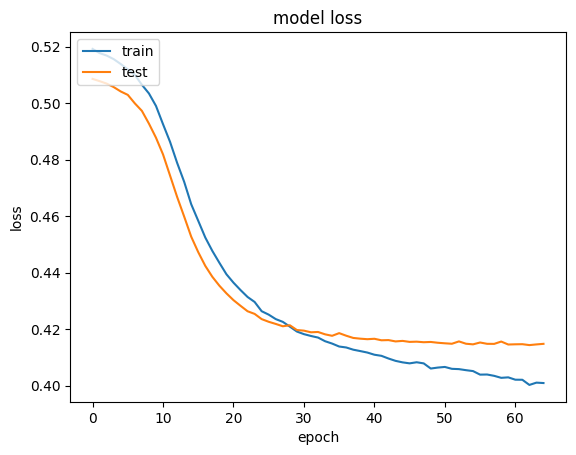

In [ ]:
plt.plot(history.history["loss"][5:])
plt.plot(history.history["val_loss"][5:])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [ ]:
refined_dataset.head()

,user id,movie title,rating,user,movie
0,1,101 Dalmatians (1996),2.0,0,2
1,1,12 Angry Men (1957),5.0,0,3
2,1,"20,000 Leagues Under the Sea (1954)",3.0,0,6
3,1,2001: A Space Odyssey (1968),4.0,0,7
4,1,"Abyss, The (1989)",3.0,0,16


In [ ]:
X_train_array

[array([180, 487, 177, ..., 431, 232, 138]),
 array([1152,  389,  302, ..., 1588,  399,  612])]

In [ ]:
user_id = [777]
encoded_user_id = user_enc.transform(user_id)

seen_movies = list(refined_dataset[refined_dataset['user id'] == user_id[0]]['movie'])
print(seen_movies)

[7, 55, 87, 113, 313, 337, 389, 390, 399, 411, 432, 460, 498, 528, 580, 604, 612, 643, 666, 783, 996, 1005, 1032, 1102, 1132, 1157, 1190, 1208, 1251, 1260, 1284, 1302, 1342, 1523, 1558, 1615]


In [ ]:
len(refined_dataset['movie'].unique()), min(refined_dataset['movie']), max(refined_dataset['movie'])

(1664, 0, 1663)

In [ ]:

unseen_movies = [i for i in range(min(refined_dataset['movie']), max(refined_dataset['movie'])+1) if i not in seen_movies]
print(unseen_movies)

[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 

In [ ]:
len(unseen_movies) + len(seen_movies)

1664

In [ ]:
model_input = [np.asarray(list(encoded_user_id)*len(unseen_movies)), np.asarray(unseen_movies)]
len(model_input), len(model_input[0])

(2, 1628)

In [ ]:
predicted_ratings = model.predict(model_input)

51/51 [==============================] - 0s 3ms/step


In [ ]:
print(predicted_ratings.shape)

(1628, 9)


In [ ]:
print(predicted_ratings)

[[8.79900932e-01 1.20075375e-01 2.75353591e-06 ... 4.26819361e-06
  3.48200729e-06 2.45421484e-06]
 [7.99674928e-01 2.00294688e-01 3.57191379e-06 ... 5.11446160e-06
  4.51249844e-06 3.11158306e-06]
 [9.48045850e-01 5.19375540e-02 1.93976507e-06 ... 3.27651924e-06
  2.47522144e-06 1.64438836e-06]
 ...
 [5.46702504e-01 4.53242242e-01 6.33804075e-06 ... 8.18050557e-06
  8.01474744e-06 6.19148614e-06]
 [6.88789308e-01 3.11170399e-01 4.49648860e-06 ... 6.30476416e-06
  5.75230297e-06 4.28375142e-06]
 [9.42289114e-01 5.76909408e-02 2.47499588e-06 ... 3.71249030e-06
  2.98471446e-06 1.89642401e-06]]


In [ ]:
predicted_ratings = np.max(predicted_ratings, axis=1)
predicted_ratings

array([0.87990093, 0.7996749 , 0.94804585, ..., 0.5467025 , 0.6887893 ,
       0.9422891 ], dtype=float32)

In [ ]:
predicted_ratings.shape

(1628,)

In [ ]:
sorted_index = np.argsort(predicted_ratings)[::-1]
print(sorted_index)


[1445  738 1220 ...  647 1404 1318]


In [ ]:
recommended_movies = item_enc.inverse_transform(sorted_index)
recommended_movies


array(['Sword in the Stone, The (1963)', 'In the Line of Duty 2 (1987)',
       'Red Firecracker, Green Firecracker (1994)', ...,
       'Gumby: The Movie (1995)', 'Steel (1997)',
       "She's So Lovely (1997)"], dtype=object)

In [ ]:
from pprint import pprint
pprint(list(recommended_movies[:20]))


['Sword in the Stone, The (1963)',
 'In the Line of Duty 2 (1987)',
 'Red Firecracker, Green Firecracker (1994)',
 'Striking Distance (1993)',
 'Meet Wally Sparks (1997)',
 'Baton Rouge (1988)',
 'Mediterraneo (1991)',
 'Conspiracy Theory (1997)',
 'Duck Soup (1933)',
 'Basic Instinct (1992)',
 'Die Hard (1988)',
 'Phat Beach (1996)',
 'Transformers: The Movie, The (1986)',
 'Jude (1996)',
 'L.A. Confidential (1997)',
 'Saint, The (1997)',
 'Smoke (1995)',
 'Jaws 2 (1978)',
 'Circle of Friends (1995)',
 'King of New York (1990)']


In [ ]:
def recommender_system(user_id, model, n_movies):

  print("")
  print("Movie seen by the User:")
  pprint(list(refined_dataset[refined_dataset['user id'] == user_id]['movie title']))
  print("")

  encoded_user_id = user_enc.transform([user_id])

  seen_movies = list(refined_dataset[refined_dataset['user id'] == user_id]['movie'])
  unseen_movies = [i for i in range(min(refined_dataset['movie']), max(refined_dataset['movie'])+1) if i not in seen_movies]
  model_input = [np.asarray(list(encoded_user_id)*len(unseen_movies)), np.asarray(unseen_movies)]
  predicted_ratings = model.predict(model_input)
  predicted_ratings = np.max(predicted_ratings, axis=1)
  sorted_index = np.argsort(predicted_ratings)[::-1]
  recommended_movies = item_enc.inverse_transform(sorted_index)
  print("---------------------------------------------------------------------------------")
  print("Top "+str(n_movies)+" Movie recommendations for the User "+str(user_id)+ " are:")
  pprint(list(recommended_movies[:n_movies]))

*Defines a function to recommend movies to a specific user based on their viewing history and predicted ratings.*

In [ ]:
print("Enter user id")
user_id= int(input())

print("Enter number of movies to be recommended:")
n_movies = int(input())
recommender_system(user_id,model,n_movies)


Enter user id
1
Enter number of movies to be recommended:
2

Movie seen by the User:
['101 Dalmatians (1996)',
 '12 Angry Men (1957)',
 '20,000 Leagues Under the Sea (1954)',
 '2001: A Space Odyssey (1968)',
 'Abyss, The (1989)',
 'Ace Ventura: Pet Detective (1994)',
 'Air Bud (1997)',
 'Akira (1988)',
 'Aladdin (1992)',
 'Alien (1979)',
 'Aliens (1986)',
 'All Dogs Go to Heaven 2 (1996)',
 'Amadeus (1984)',
 'Angels and Insects (1995)',
 "Antonia's Line (1995)",
 'Apocalypse Now (1979)',
 'Apollo 13 (1995)',
 'Aristocats, The (1970)',
 'Army of Darkness (1993)',
 'Austin Powers: International Man of Mystery (1997)',
 'Babe (1995)',
 'Back to the Future (1985)',
 'Bad Boys (1995)',
 'Basic Instinct (1992)',
 'Batman & Robin (1997)',
 'Batman Forever (1995)',
 'Batman Returns (1992)',
 'Beavis and Butt-head Do America (1996)',
 'Bedknobs and Broomsticks (1971)',
 'Belle de jour (1967)',
 'Big Night (1996)',
 'Billy Madison (1995)',
 'Birdcage, The (1996)',
 'Blade Runner (1982)',
 'Blue

 *Prompts the user for input to interactively recommend movies based on the entered user ID and number of movies.*

# **Recommendation System 3**

In [ ]:
import pandas as pd

# https://files.grouplens.org/datasets/movielens/ml-25m.zip
movies = pd.read_csv("/content/movies.csv")

*Loads movie data from a CSV (movies.csv) and cleans movie titles by removing non-alphanumeric characters.*

In [ ]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
import re

def clean_title(title):
    title = re.sub("[^a-zA-Z0-9 ]", "", title)
    return title

In [ ]:
movies["clean_title"] = movies["title"].apply(clean_title)

In [ ]:
movies

,movieId,title,genres,clean_title
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Toy Story 1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,Jumanji 1995
2,3,Grumpier Old Men (1995),Comedy|Romance,Grumpier Old Men 1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,Waiting to Exhale 1995
4,5,Father of the Bride Part II (1995),Comedy,Father of the Bride Part II 1995
...,...,...,...,...
62418,209157,We (2018),Drama,We 2018
62419,209159,Window of the Soul (2001),Documentary,Window of the Soul 2001
62420,209163,Bad Poems (2018),Comedy|Drama,Bad Poems 2018
62421,209169,A Girl Thing (2001),(no genres listed),A Girl Thing 2001


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(ngram_range=(1,2))

tfidf = vectorizer.fit_transform(movies["clean_title"])

*Uses TfidfVectorizer from Scikit-learn to convert cleaned movie titles into TF-IDF vectors to represent each movie.*

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def search(title):
    title = clean_title(title)
    query_vec = vectorizer.transform([title])
    similarity = cosine_similarity(query_vec, tfidf).flatten()
    indices = np.argpartition(similarity, -5)[-5:]
    results = movies.iloc[indices].iloc[::-1]

    return results

*Defines a function search(title) that takes a movie title input, cleans it, computes its TF-IDF vector, calculates cosine similarity with all movies, and returns the top 5 most similar movies based on cosine similarity scores.*

In [ ]:
!pip install ipywidgets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.3 MB/s eta 0:00:00


In [ ]:
import ipywidgets as widgets
from IPython.display import display

movie_input = widgets.Text(
    value='Toy Story',
    description='Movie Title:',
    disabled=False
)
movie_list = widgets.Output()

def on_type(data):
    with movie_list:
        movie_list.clear_output()
        title = data["new"]
        if len(title) > 5:
            display(search(title))

movie_input.observe(on_type, names='value')


display(movie_input, movie_list)

Text(value='Toy Story', description='Movie Title:')

Output()

*Utilizes ipywidgets to create an interactive text input (movie_input) that displays the top 5 similar movies dynamically as the user types in a movie title.*

In [ ]:
movie_id = 89745

#def find_similar_movies(movie_id):
movie = movies[movies["movieId"] == movie_id]

In [93]:
ratings = pd.read_csv("/content/ratings.csv")

In [94]:
ratings

,userId,movieId,rating,timestamp
0,1,296,5.0,1.147880e+09
1,1,306,3.5,1.147869e+09
2,1,307,5.0,1.147869e+09
3,1,665,5.0,1.147879e+09
4,1,899,3.5,1.147869e+09
...,...,...,...,...
290998,2010,266,1.0,9.725270e+08
290999,2010,317,2.0,9.725266e+08
291000,2010,367,5.0,9.725266e+08
291001,2010,527,4.0,9.725265e+08


from matplotlib import pyplot as plt
ratings['userId'].plot(kind='hist', bins=20, title='userId')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
ratings['movieId'].plot(kind='hist', bins=20, title='movieId')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
ratings['rating'].plot(kind='hist', bins=20, title='rating')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
ratings['timestamp'].plot(kind='hist', bins=20, title='timestamp')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
ratings.plot(kind='scatter', x='userId', y='movieId', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
ratings.plot(kind='scatter', x='movieId', y='rating', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
ratings.plot(kind='scatter', x='rating', y='timestamp', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['userId']
  ys = series['movieId']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = ratings.sort_values('userId', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('userId')
_ = plt.ylabel('movieId')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['userId']
  ys = series['rating']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = ratings.sort_values('userId', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('userId')
_ = plt.ylabel('rating')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['userId']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'userId'}, axis=1)
              .sort_values('userId', ascending=True))
  xs = counted['userId']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = ratings.sort_values('userId', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('userId')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['timestamp']
  ys = series['movieId']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = ratings.sort_values('timestamp', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('timestamp')
_ = plt.ylabel('movieId')

from matplotlib import pyplot as plt
ratings['userId'].plot(kind='line', figsize=(8, 4), title='userId')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
ratings['movieId'].plot(kind='line', figsize=(8, 4), title='movieId')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
ratings['rating'].plot(kind='line', figsize=(8, 4), title='rating')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
ratings['timestamp'].plot(kind='line', figsize=(8, 4), title='timestamp')
plt.gca().spines[['top', 'right']].set_visible(False)

In [95]:
ratings.dtypes

userId         int64
movieId        int64
rating       float64
timestamp    float64
dtype: object

In [96]:
similar_users = ratings[(ratings["movieId"] == movie_id) & (ratings["rating"] > 4)]["userId"].unique()

In [97]:
similar_user_recs = ratings[(ratings["userId"].isin(similar_users)) & (ratings["rating"] > 4)]["movieId"]

In [98]:
similar_user_recs = similar_user_recs.value_counts() / len(similar_users)

similar_user_recs = similar_user_recs[similar_user_recs > .10]

In [99]:
all_users = ratings[(ratings["movieId"].isin(similar_user_recs.index)) & (ratings["rating"] > 4)]

In [100]:
all_user_recs = all_users["movieId"].value_counts() / len(all_users["userId"].unique())

In [101]:
rec_percentages = pd.concat([similar_user_recs, all_user_recs], axis=1)
rec_percentages.columns = ["similar", "all"]

In [102]:
rec_percentages

,similar,all
movieId,,
89745,1.000000,0.045797
58559,0.635294,0.133082
79132,0.588235,0.132004
2571,0.541176,0.239763
59315,0.482353,0.051185
...,...,...
85414,0.105882,0.017780
122918,0.105882,0.012931
53125,0.105882,0.010237


from matplotlib import pyplot as plt
_df_2['similar'].plot(kind='hist', bins=20, title='similar')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['all'].plot(kind='hist', bins=20, title='all')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4['score'].plot(kind='hist', bins=20, title='score')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='similar', y='all', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='all', y='score', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7['similar'].plot(kind='line', figsize=(8, 4), title='similar')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_8['all'].plot(kind='line', figsize=(8, 4), title='all')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_9['score'].plot(kind='line', figsize=(8, 4), title='score')
plt.gca().spines[['top', 'right']].set_visible(False)

In [103]:
rec_percentages["score"] = rec_percentages["similar"] / rec_percentages["all"]

In [104]:
rec_percentages = rec_percentages.sort_values("score", ascending=False)

In [105]:
rec_percentages.head(10).merge(movies, left_index=True, right_on="movieId")

,similar,all,score,movieId,title,genres,clean_title
17067,1.000000,0.045797,21.835294,89745,"Avengers, The (2012)",Action|Adventure|Sci-Fi|IMAX,Avengers The 2012
16312,0.141176,0.009159,15.413149,86332,Thor (2011),Action|Adventure|Drama|Fantasy|IMAX,Thor 2011
25071,0.235294,0.016703,14.087287,122920,Captain America: Civil War (2016),Action|Sci-Fi|Thriller,Captain America Civil War 2016
25058,0.188235,0.013470,13.974588,122892,Avengers: Age of Ultron (2015),Action|Adventure|Sci-Fi,Avengers Age of Ultron 2015
16725,0.164706,0.011853,13.895187,88140,Captain America: The First Avenger (2011),Action|Adventure|Sci-Fi|Thriller|War,Captain America The First Avenger 2011
21606,0.270588,0.019935,13.573291,111362,X-Men: Days of Future Past (2014),Action|Adventure|Sci-Fi,XMen Days of Future Past 2014
25068,0.129412,0.009698,13.343791,122914,Avengers: Infinity War - Part II (2019),Action|Adventure|Sci-Fi,Avengers Infinity War Part II 2019
21348,0.258824,0.019397,13.343791,110102,Captain America: The Winter Soldier (2014),Action|Adventure|Sci-Fi|IMAX,Captain America The Winter Soldier 2014
19678,0.176471,0.013470,13.101176,102125,Iron Man 3 (2013),Action|Sci-Fi|Thriller|IMAX,Iron Man 3 2013
22572,0.200000,0.015625,12.800000,115617,Big Hero 6 (2014),Action|Animation|Comedy,Big Hero 6 2014


from matplotlib import pyplot as plt
_df_10['similar'].plot(kind='hist', bins=20, title='similar')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_11['all'].plot(kind='hist', bins=20, title='all')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_12['score'].plot(kind='hist', bins=20, title='score')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_13['movieId'].plot(kind='hist', bins=20, title='movieId')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_14.groupby('genres').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_15.plot(kind='scatter', x='similar', y='all', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_16.plot(kind='scatter', x='all', y='score', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_17.plot(kind='scatter', x='score', y='movieId', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_18['similar'].plot(kind='line', figsize=(8, 4), title='similar')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_19['all'].plot(kind='line', figsize=(8, 4), title='all')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_20['score'].plot(kind='line', figsize=(8, 4), title='score')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_21['movieId'].plot(kind='line', figsize=(8, 4), title='movieId')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_22['genres'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_22, x='similar', y='genres', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_23['genres'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_23, x='all', y='genres', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_24['genres'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_24, x='score', y='genres', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_25['genres'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_25, x='movieId', y='genres', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [106]:
def find_similar_movies(movie_id):
    similar_users = ratings[(ratings["movieId"] == movie_id) & (ratings["rating"] > 4)]["userId"].unique()
    similar_user_recs = ratings[(ratings["userId"].isin(similar_users)) & (ratings["rating"] > 4)]["movieId"]
    similar_user_recs = similar_user_recs.value_counts() / len(similar_users)

    similar_user_recs = similar_user_recs[similar_user_recs > .10]
    all_users = ratings[(ratings["movieId"].isin(similar_user_recs.index)) & (ratings["rating"] > 4)]
    all_user_recs = all_users["movieId"].value_counts() / len(all_users["userId"].unique())
    rec_percentages = pd.concat([similar_user_recs, all_user_recs], axis=1)
    rec_percentages.columns = ["similar", "all"]

    rec_percentages["score"] = rec_percentages["similar"] / rec_percentages["all"]
    rec_percentages = rec_percentages.sort_values("score", ascending=False)
    return rec_percentages.head(10).merge(movies, left_index=True, right_on="movieId")[["score", "title", "genres"]]

*Finds movies similar to a specified movie (movie_id) based on user ratings.
Filters users who rated the specified movie highly (rating > 4) and identifies other movies highly rated by these users.
Calculates a score based on the proportion of similar ratings to all ratings for each recommended movie.*

In [107]:
import ipywidgets as widgets
from IPython.display import display

movie_name_input = widgets.Text(
    value='Toy Story',
    description='Movie Title:',
    disabled=False
)
recommendation_list = widgets.Output()

def on_type(data):
    with recommendation_list:
        recommendation_list.clear_output()
        title = data["new"]
        if len(title) > 5:
            results = search(title)
            movie_id = results.iloc[0]["movieId"]
            display(find_similar_movies(movie_id))

movie_name_input.observe(on_type, names='value')

display(movie_name_input, recommendation_list)

Text(value='Toy Story', description='Movie Title:')

Output()

from matplotlib import pyplot as plt
_df_0['score'].plot(kind='hist', bins=20, title='score')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['score'].plot(kind='line', figsize=(8, 4), title='score')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_26['score'].plot(kind='hist', bins=20, title='score')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_27.groupby('genres').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_28['score'].plot(kind='line', figsize=(8, 4), title='score')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_29['genres'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_29, x='score', y='genres', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

*Implements another interactive text input (movie_name_input) that dynamically displays recommendations for movies similar to the input movie title, using the previously defined functions (search and find_similar_movies).*